## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Funciones

In [2]:
# Función que transforma variables categóricas a WoE (Weight of Evidence)
def calcular_woe(df, variable, target, eps=0.5):
    # Crear tabla de frecuencia
    tabla = pd.crosstab(df[variable], df[target])
    tabla.columns = ['Descartado', 'Fraude']

    # Debido a que hay pocos casos catalogados como fraudes, se aplica un epsilon para suavizar 
    tabla = tabla + eps
    
    # Calcular proporciones
    tabla['Distrib_Descartado'] = tabla['Descartado'] / tabla['Descartado'].sum()
    tabla['Distrib_Fraude'] = tabla['Fraude'] / tabla['Fraude'].sum()
    
    # Calcular WoE
    tabla['WOE'] = np.log(tabla['Distrib_Descartado'] / tabla['Distrib_Fraude']).replace([np.inf, -np.inf], 0)
    
    return tabla[['WOE']]

## Dataset

In [5]:
df = pd.read_csv('dataset.csv', sep = '|')

In [7]:
df

,CLAIM_ID,FEC_DENUNCIO,FEC_SINIESTRO,PRODUCTO,ROBO,MARCA_VEHICULO,ANIO_VEHICULO,DEDUCIBLE,PRIMA_MENSUAL_UF,FRAUD,MONTO_FRAUDE,CANAL_CONTRATACION,CANTIDAD_HIJOS,CANTIDAD_AUTOS,ESTADO_CIVIL
0,1,2024-10-10 00:00:00.000,2024-10-04 00:00:00.000,95.0,0,BMW,2022.0,10,2.988041,No revisado,0,D,1.0,NaN,Soltero/a
1,2,2024-10-10 00:00:00.000,2024-10-08 00:00:00.000,3.0,0,MAXUS,2024.0,5,1.197945,Descartado,0,D,1.0,NaN,Divorciado/a
2,3,2024-10-10 00:00:00.000,2024-09-16 00:00:00.000,3.0,0,CHERY,2024.0,0,0.446656,No revisado,0,D,0.0,NaN,Casada/o
3,4,2024-10-10 00:00:00.000,2024-10-09 00:00:00.000,96.0,0,RENAULT,2022.0,5,0.857671,No revisado,0,C,1.0,NaN,Casada/o
4,5,2024-10-10 00:00:00.000,2024-10-09 00:00:00.000,74.0,0,MG,2019.0,3,0.415890,Descartado,0,C,2.0,NaN,Divorciado/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28276,28277,2025-03-09 00:00:00.000,2025-03-08 00:00:00.000,3.0,0,JEEP,2014.0,0,0.618904,Descartado,0,C,0.0,NaN,Casada/o
28277,28278,2025-03-09 00:00:00.000,2025-03-08 00:00:00.000,69.0,0,SUBARU,2023.0,10,0.895479,Descartado,0,B,0.0,NaN,Divorciado/a
28278,28279,2025-03-09 00:00:00.000,2025-03-09 00:00:00.000,74.0,0,HYUNDAI,2013.0,0,0.985068,Descartado,0,C,0.0,NaN,Divorciado/a
28279,28280,2025-03-09 00:00:00.000,2025-03-07 00:00:00.000,90.0,0,CHERY,2022.0,5,0.754110,No revisado,0,B,0.0,NaN,Soltero/a


## Exploración de los datos

In [9]:
for i in df.columns:
    missing_q = df[i].isna().sum()
    total_q = len(df)
    missing_perc = missing_q / total_q * 100
    print('\nColumna', i)
    print('Tipo de la columna:', df[i].dtypes)
    print('Cantidad de missings:', missing_q)
    print('Porcentaje de missings (%):', missing_perc)


Columna CLAIM_ID
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna FEC_DENUNCIO
Tipo de la columna: object
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna FEC_SINIESTRO
Tipo de la columna: object
Cantidad de missings: 354
Porcentaje de missings (%): 1.2517237721438421

Columna PRODUCTO
Tipo de la columna: float64
Cantidad de missings: 339
Porcentaje de missings (%): 1.1986846292563913

Columna ROBO
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna MARCA_VEHICULO
Tipo de la columna: object
Cantidad de missings: 284
Porcentaje de missings (%): 1.0042077720024043

Columna ANIO_VEHICULO
Tipo de la columna: float64
Cantidad de missings: 595
Porcentaje de missings (%): 2.1038860012022207

Columna DEDUCIBLE
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna PRIMA_MENSUAL_UF
Tipo de la columna: float64
Cantidad de missings: 200
Porcentaje de missings (%): 

In [11]:
# Revisión de variables categóricas
categ_vars = ['PRODUCTO', 'ROBO', 'MARCA_VEHICULO', 'ANIO_VEHICULO', 'FRAUD', 'CANAL_CONTRATACION', 'ESTADO_CIVIL']

# Se verá los valores que toman cada una de estas variables
for i in categ_vars:
    categ_uniq = df[i].unique()
    print('\nVariable categórica', i)
    print('Valores únicos:', categ_uniq)


Variable categórica PRODUCTO
Valores únicos: [ 95.   3.  96.  74.  94.  69.  90.  85.  91.  83.  nan  92.  33.  93.
  73.  35. 102. 114.  75.]

Variable categórica ROBO
Valores únicos: [0 1]

Variable categórica MARCA_VEHICULO
Valores únicos: ['BMW' 'MAXUS' 'CHERY' 'RENAULT' 'MG' 'TOYOTA' 'MERCEDES BENZ' 'CITROEN'
 'PEUGEOT' 'RAM' 'SUZUKI' 'MAZDA' 'JEEP' 'NISSAN' 'SCANIA' nan
 'INTERNATIONAL' 'CHEVROLET' 'KIA' 'FORD' 'VOLKSWAGEN' 'REPCO' 'SSANGYONG'
 'CHANGAN' 'HAVAL' 'MITSUBISHI' 'VOLVO' 'SUBARU' 'MAHINDRA' 'FIAT' 'JAC'
 'HYUNDAI' 'HONDA' 'EXEED' 'GREAT WALL' 'OMODA' 'MINI' 'VOLARE' 'SKODA'
 'AUDI' 'JORCKA' 'HINO' 'KARRY' 'RANDON' 'MITSUBISHI FUSO ' 'GAC' 'JETOUR'
 'DFSK' 'GEELY' 'BAJAJ' 'OPEL' 'DFM' 'DODGE' 'MARCOPOLO' 'YOUYI'
 'LAND ROVER' 'DUCATI' 'FAW' 'DS' 'MACHILE' 'PORSCHE' 'YAMAHA' 'BAIC'
 'JMC' 'MACK' 'KENWORTH' 'KAIYI' 'SEAT' 'FREIGHTLINER' 'FOTON' 'HDI' 'MAN'
 'UTILITY' 'BYD' 'MUSSRE' 'TREMAC' 'CUPRA' 'SAMSUNG' 'BRILLIANCE' 'AGRALE'
 'IVECO' 'FACCHINI' 'INDIAN' 'TRIUMPH' '

In [13]:
# La variable objetivo es FRAUD, ya que hay que clasificar si una denuncia es un fraude o no
# Hay que revisar que porcentaje de los registros corresponde a cada clasificación de la variable FRAUD
df_fraud = df.groupby(by = ['FRAUD']).agg(REGISTROS = ('CLAIM_ID', 'count')).reset_index()
df_fraud['PORC_REGISTROS'] = df_fraud['REGISTROS']/len(df) * 100
df_fraud

,FRAUD,REGISTROS,PORC_REGISTROS
0,Descartado,10496,37.113256
1,Fraude,325,1.149181
2,No revisado,17460,61.737562


In [15]:
# La variable objetivo es FRAUD, ya que hay que clasificar si una denuncia es un fraude o no
# Hay que revisar que porcentaje de los registros corresponde a cada clasificación de la variable FRAUD
df_fraud_v2 = df[df['FRAUD'] != 'No revisado'].groupby(by = ['FRAUD']).agg(REGISTROS = ('CLAIM_ID', 'count')).reset_index()
df_fraud_v2['PORC_REGISTROS'] = df_fraud_v2['REGISTROS']/len(df[df['FRAUD'] != 'No revisado']) * 100
df_fraud_v2

,FRAUD,REGISTROS,PORC_REGISTROS
0,Descartado,10496,96.996581
1,Fraude,325,3.003419


In [17]:
# Debido a que la variable CANTIDAD_AUTOS es la que mayor porcentaje de missings tiene (90%)
# Se revisará si hay alguna diferencia entre clasificación de la variable FRAUD
df_fraud_cars = df.groupby(by = ['FRAUD']).agg(REGISTROS_AUTOS = ('CANTIDAD_AUTOS', 'count')).reset_index()
df_fraud_cars = df_fraud_cars.merge(df_fraud[['FRAUD', 'REGISTROS']], on = ['FRAUD'], how = 'inner')
df_fraud_cars['PORC_REGISTROS_AUTOS'] = df_fraud_cars['REGISTROS_AUTOS']/df_fraud_cars['REGISTROS'] * 100
df_fraud_cars

,FRAUD,REGISTROS_AUTOS,REGISTROS,PORC_REGISTROS_AUTOS
0,Descartado,1095,10496,10.432546
1,Fraude,32,325,9.846154
2,No revisado,1777,17460,10.177549


In [19]:
# Se realizará lo mismo que la celda anterior, pero también segmentando por la columna ROBO
df_fraud_cars_robo = df.groupby(by = ['ROBO', 'FRAUD']).agg(REGISTROS = ('CLAIM_ID', 'count'), 
                                                            REGISTROS_AUTOS = ('CANTIDAD_AUTOS', 'count')).reset_index()
df_fraud_cars_robo['PORC_REGISTROS_AUTOS'] = df_fraud_cars_robo['REGISTROS_AUTOS']/df_fraud_cars_robo['REGISTROS'] * 100
df_fraud_cars_robo

,ROBO,FRAUD,REGISTROS,REGISTROS_AUTOS,PORC_REGISTROS_AUTOS
0,0,Descartado,9673,1003,10.369069
1,0,Fraude,295,27,9.152542
2,0,No revisado,17271,1758,10.178913
3,1,Descartado,823,92,11.178615
4,1,Fraude,30,5,16.666667
5,1,No revisado,189,19,10.052910


Ya que la variable CANTIDAD_AUTOS tiene un alto porcentaje de missings, independiente de la categoría de fraude, se decide eliminar

In [21]:
# Revisión de variables numéricas
num_vars = ['CLAIM_ID', 'DEDUCIBLE', 'PRIMA_MENSUAL_UF', 'MONTO_FRAUDE', 'CANTIDAD_HIJOS', 'CANTIDAD_AUTOS']

df[num_vars].describe()

,CLAIM_ID,DEDUCIBLE,PRIMA_MENSUAL_UF,MONTO_FRAUDE,CANTIDAD_HIJOS,CANTIDAD_AUTOS
count,28281.000000,28281.000000,28081.000000,28281.000000,25448.000000,2904.000000
mean,14141.000000,5.464976,0.872245,319.859623,53.888832,1.192837
std,8164.165818,8.630600,0.611854,5880.129032,224.314478,0.394594
min,1.000000,0.000000,0.001252,0.000000,0.000000,1.000000
25%,7071.000000,3.000000,0.560959,0.000000,0.000000,1.000000
50%,14141.000000,5.000000,0.726781,0.000000,0.000000,1.000000
75%,21211.000000,10.000000,0.988767,0.000000,1.000000,1.000000
max,28281.000000,500.000000,18.936370,542264.000000,999.000000,2.000000


## Transformación de datos

In [23]:
# Las columnas que correspondan a fecha hay que transformarlas al formato correspondiente
df['FEC_DENUNCIO'] = pd.to_datetime(df['FEC_DENUNCIO'], format = '%Y-%m-%d')
df['FEC_SINIESTRO'] = pd.to_datetime(df['FEC_SINIESTRO'], format = '%Y-%m-%d')

In [25]:
# Para los valores de ESTADO_CIVIL se dejan valores iguales
dicc_estado_civil = {'Soltero/a': 'SOLTERO', 
                     'Divorciado/a': 'DIVORCIADO', 
                     'Casada/o': 'CASADO', 
                     'Divorciado': 'DIVORCIADO', 
                     'Casada': 'CASADO'}
df['ESTADO_CIVIL'] = df['ESTADO_CIVIL'].replace(dicc_estado_civil)

In [27]:
# Se deben eliminar los casos atipicos de cantidad de hijos
# Se tiene un valor atípico de 999, por lo que se eliminará ese valor
df = df[df['CANTIDAD_HIJOS'] != 999]

In [29]:
# En la variable ANIO_VEHICULO hay un registro que indica que un auto es del año 2030, lo cual no es posible
df = df[df['ANIO_VEHICULO'] != 2030]

In [31]:
print("Antes de KNN:", df.shape)

# Para el caso de ANIO_VEHICULOS, CANTIDAD_HIJOS y PRIMA_MENSUAL_UF, se rellenan los missings usando el método KNN
knn_vars = ['ANIO_VEHICULO', 'CANTIDAD_HIJOS', 'PRIMA_MENSUAL_UF']
df_knn = df[knn_vars]

# Se crea el imputador con una cantidad de vecinos de 10
imputer = KNNImputer(n_neighbors=10) 

# Ajustar e imputar
df_imput = imputer.fit_transform(df_knn)
df[knn_vars] = pd.DataFrame(df_imput, columns=knn_vars, index=df.index)

print("Después de KNN:", df.shape)

Antes de KNN: (26923, 15)
Después de KNN: (26923, 15)


In [33]:
df[knn_vars].describe()

,ANIO_VEHICULO,CANTIDAD_HIJOS,PRIMA_MENSUAL_UF
count,26923.000000,26923.000000,26923.000000
mean,2020.266586,0.662006,0.872308
std,5.327732,0.866931,0.613427
min,1900.000000,0.000000,0.001252
25%,2018.000000,0.000000,0.562192
50%,2022.000000,0.000000,0.726986
75%,2023.000000,1.000000,0.987945
max,2025.000000,3.000000,18.936370


In [35]:
# Se deben eliminar los casos en que ciertos registros sean nulos
# Esto ocurre para las variables FEC_SINIESTRO, PRODUCTO, MARCA_VEHICULO y ESTADO_CIVIL
# Se decide hacer esto con estas columnas debido a que sus valores nulos no se pueden llenar de forma consistente
df = df.dropna(subset = ['FEC_SINIESTRO', 'PRODUCTO', 'MARCA_VEHICULO', 'ESTADO_CIVIL'])

In [39]:
# Se elimina la variable de cantidad autos por el alto porcentaje de missings
df = df.drop(['CANTIDAD_AUTOS'], axis = 1)

In [43]:
# Además de las variables que venían desde un comienzo, se agregan nuevas para complementar la creación de modelos

# Variable de días entre la fecha del siniestro y la fecha de denuncia
df['DIAS_SIN_DEN'] = (df['FEC_DENUNCIO'] - df['FEC_SINIESTRO']).dt.days

# Variable de día de la semana del siniestro y denuncia (1=Lunes, …, 7=Domingo)
df['WEEKDAY_SINIESTRO'] = df['FEC_SINIESTRO'].dt.weekday + 1
df['WEEKDAY_DENUNCIO']  = df['FEC_DENUNCIO'].dt.weekday + 1

# Variable de día del siniestro y denuncia
df['DAY_SINIESTRO'] = df['FEC_SINIESTRO'].dt.day
df['DAY_DENUNCIO']  = df['FEC_DENUNCIO'].dt.day

# Variable de mes del siniestro y denuncia
df['MONTH_SINIESTRO'] = df['FEC_SINIESTRO'].dt.month
df['MONTH_DENUNCIO']  = df['FEC_DENUNCIO'].dt.month

# Variable de años de antigüedad del vehículo con respecto al año actual
anio_actual = pd.Timestamp.now().year
df['ANT_VEHICULO'] = anio_actual - df['ANIO_VEHICULO']

# Variable de ratio entre prima y deducible
df['RATIO_PRIMA_DEDUCIBLE'] = np.where(df['DEDUCIBLE'] == 0, 0, df['PRIMA_MENSUAL_UF'] / df['DEDUCIBLE'])

# Variable de prima por robo
df['PRIMA_POR_ROBO'] = df['PRIMA_MENSUAL_UF'] * df['ROBO']

# Variable de prima por hijos
df['PRIMA_POR_HIJO'] = df['PRIMA_MENSUAL_UF'] * df['CANTIDAD_HIJOS']

# Variable de prima por antigüedad del vehículo
df['PRIMA_POR_ANT'] = df['PRIMA_MENSUAL_UF'] * df['ANT_VEHICULO']

# Variable de deducible por robo
df['DEDUCIBLE_POR_ROBO'] = df['DEDUCIBLE'] * df['ROBO']

# Variable de deducible por hijos
df['DEDUCIBLE_POR_HIJO'] = df['DEDUCIBLE'] * df['CANTIDAD_HIJOS']

# Variable de deducible por antigüedad del vehículo
df['DEDUCIBLE_POR_ANT'] = df['DEDUCIBLE'] * df['ANT_VEHICULO']

In [45]:
# Aplicar columna WOE a variables categóricas

# MARCA_VEHICULO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'MARCA_VEHICULO', 'FRAUD')
df['MARCA_VEHICULO_WOE'] = df['MARCA_VEHICULO'].map(woe_marca['WOE'])

# ESTADO_CIVIL
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'ESTADO_CIVIL', 'FRAUD')
df['ESTADO_CIVIL_WOE'] = df['ESTADO_CIVIL'].map(woe_marca['WOE'])

# CANAL_CONTRATACION
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'CANAL_CONTRATACION', 'FRAUD')
df['CANAL_CONTRATACION_WOE'] = df['CANAL_CONTRATACION'].map(woe_marca['WOE'])

# PRODUCTO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'PRODUCTO', 'FRAUD')
df['PRODUCTO_WOE'] = df['PRODUCTO'].map(woe_marca['WOE'])

# WEEKDAY_SINIESTRO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'WEEKDAY_SINIESTRO', 'FRAUD')
df['WEEKDAY_SINIESTRO_WOE'] = df['WEEKDAY_SINIESTRO'].map(woe_marca['WOE'])

# WEEKDAY_DENUNCIO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'WEEKDAY_DENUNCIO', 'FRAUD')
df['WEEKDAY_DENUNCIO_WOE'] = df['WEEKDAY_DENUNCIO'].map(woe_marca['WOE'])

# MONTH_SINIESTRO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'MONTH_SINIESTRO', 'FRAUD')
df['MONTH_SINIESTRO_WOE'] = df['MONTH_SINIESTRO'].map(woe_marca['WOE'])

# MONTH_DENUNCIO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'MONTH_DENUNCIO', 'FRAUD')
df['MONTH_DENUNCIO_WOE'] = df['MONTH_DENUNCIO'].map(woe_marca['WOE'])

# DAY_SINIESTRO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'DAY_SINIESTRO', 'FRAUD')
df['DAY_SINIESTRO_WOE'] = df['DAY_SINIESTRO'].map(woe_marca['WOE'])

# MONTH_DENUNCIO
woe_marca = calcular_woe(df[df['FRAUD'] != 'No revisado'], 'DAY_DENUNCIO', 'FRAUD')
df['DAY_DENUNCIO_WOE'] = df['DAY_DENUNCIO'].map(woe_marca['WOE'])

In [47]:
df

,CLAIM_ID,FEC_DENUNCIO,FEC_SINIESTRO,PRODUCTO,ROBO,MARCA_VEHICULO,ANIO_VEHICULO,DEDUCIBLE,PRIMA_MENSUAL_UF,FRAUD,...,MARCA_VEHICULO_WOE,ESTADO_CIVIL_WOE,CANAL_CONTRATACION_WOE,PRODUCTO_WOE,WEEKDAY_SINIESTRO_WOE,WEEKDAY_DENUNCIO_WOE,MONTH_SINIESTRO_WOE,MONTH_DENUNCIO_WOE,DAY_SINIESTRO_WOE,DAY_DENUNCIO_WOE
0,1,2024-10-10,2024-10-04,95.0,0,BMW,2022.0,10,2.988041,No revisado,...,0.202069,0.013647,0.017444,-0.323732,-0.072994,-0.159657,-0.138772,-0.167551,0.928947,0.320928
1,2,2024-10-10,2024-10-08,3.0,0,MAXUS,2024.0,5,1.197945,Descartado,...,-0.531493,0.151532,0.017444,-0.292006,0.034995,-0.159657,-0.138772,-0.167551,1.040716,0.320928
2,3,2024-10-10,2024-09-16,3.0,0,CHERY,2024.0,0,0.446656,No revisado,...,0.747193,-0.086901,0.017444,-0.292006,0.091084,-0.159657,1.588889,-0.167551,0.068462,0.320928
3,4,2024-10-10,2024-10-09,96.0,0,RENAULT,2022.0,5,0.857671,No revisado,...,0.013543,-0.086901,0.105239,-0.004210,0.310183,-0.159657,-0.138772,-0.167551,0.318674,0.320928
4,5,2024-10-10,2024-10-09,74.0,0,MG,2019.0,3,0.415890,Descartado,...,0.778545,0.151532,0.105239,0.056527,0.310183,-0.159657,-0.138772,-0.167551,0.318674,0.320928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28276,28277,2025-03-09,2025-03-08,3.0,0,JEEP,2014.0,0,0.618904,Descartado,...,1.532720,-0.086901,0.105239,-0.292006,-0.147163,0.032165,1.261957,1.177649,1.040716,0.275243
28277,28278,2025-03-09,2025-03-08,69.0,0,SUBARU,2023.0,10,0.895479,Descartado,...,0.001398,0.151532,-0.048083,-0.031794,-0.147163,0.032165,1.261957,1.177649,1.040716,0.275243
28278,28279,2025-03-09,2025-03-09,74.0,0,HYUNDAI,2013.0,0,0.985068,Descartado,...,-0.270191,0.151532,0.105239,0.056527,-0.138180,0.032165,1.261957,1.177649,0.318674,0.275243
28279,28280,2025-03-09,2025-03-07,90.0,0,CHERY,2022.0,5,0.754110,No revisado,...,0.747193,0.013647,-0.048083,0.358746,-0.072994,0.032165,1.261957,1.177649,0.269531,0.275243


In [49]:
# Hay casos de marcas de vehículos que no están en los casos de fraudes y no fraudes, así que se rellenan los missings con 0
df['MARCA_VEHICULO_WOE'] = df['MARCA_VEHICULO_WOE'].fillna(value = 0)

In [51]:
for i in df.columns:
    missing_q = df[i].isna().sum()
    total_q = len(df)
    missing_perc = missing_q / total_q * 100
    print('\nColumna', i)
    print('Tipo de la columna:', df[i].dtypes)
    print('Cantidad de missings:', missing_q)
    print('Porcentaje de missings (%):', missing_perc)


Columna CLAIM_ID
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna FEC_DENUNCIO
Tipo de la columna: datetime64[ns]
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna FEC_SINIESTRO
Tipo de la columna: datetime64[ns]
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna PRODUCTO
Tipo de la columna: float64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna ROBO
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna MARCA_VEHICULO
Tipo de la columna: object
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna ANIO_VEHICULO
Tipo de la columna: float64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna DEDUCIBLE
Tipo de la columna: int64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna PRIMA_MENSUAL_UF
Tipo de la columna: float64
Cantidad de missings: 0
Porcentaje de missings (%): 0.0

Columna FRAUD
Tipo de la columna: object
Cantidad

## Isolation Forest

In [53]:
# Se prepara un dataframe para el entrenamiento del modelo de regresión logística
df_iso_for = df.copy()

# Se dejan solo los casos catalogados como fraudes y descartados
df_iso_for = df_iso_for[df_iso_for['FRAUD'] != 'No revisado']

# También se eliminan las columnas que no se usaran, exceptuando CLAIM_ID, para asegurar replicabilidad
df_iso_for = df_iso_for.drop(['FEC_DENUNCIO', 
                              'FEC_SINIESTRO', 
                              'MARCA_VEHICULO', 
                              'PRODUCTO', 
                              'CANAL_CONTRATACION', 
                              'ESTADO_CIVIL', 
                              'WEEKDAY_SINIESTRO', 
                              'WEEKDAY_DENUNCIO', 
                              'MONTH_SINIESTRO', 
                              'MONTH_DENUNCIO', 
                              'DAY_SINIESTRO', 
                              'DAY_DENUNCIO', 
                              'MONTO_FRAUDE'], axis = 1) # no se usa monto fraude debido a que podría sesgar el modelo

In [55]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# X: variables predictoras
# y: variable objetivo

df_iso_for = df_iso_for[df_iso_for['FRAUD'].isin(['Fraude', 'Descartado'])].copy()
df_iso_for['FRAUD'] = df_iso_for['FRAUD'].map({'Descartado': 0, 'Fraude': 1})

X = df_iso_for.drop(columns=['FRAUD', 'CLAIM_ID'])
y = df_iso_for['FRAUD'].astype(int)

# Lista de valores a probar
contamination_values = [0.01, 0.02, 0.0305, 0.04, 0.05, 0.1]
n_estimators_values = [100, 200, 300, 400, 500, 750, 1000]
results = []

for n in n_estimators_values:
    for cont in contamination_values:
        print(f"\nEvaluando modelo con contamination = {cont}")
        print(f"Evaluando modelo con estimadores = {n}")
    
        iso_model = IsolationForest(
            contamination=cont,
            n_estimators=n,
            random_state=123
        )
        
        iso_model.fit(X)
        
        # Predicciones (-1 = outlier, 1 = normal), invertimos para alinearlo con 1 = fraude
        preds = iso_model.predict(X)
        preds = [1 if p == -1 else 0 for p in preds]
    
        # Métricas
        roc = roc_auc_score(y, preds)
        cm = confusion_matrix(y, preds)
        report = classification_report(y, preds, output_dict=True)
        
        results.append({
            'contamination': cont,
            'n_estimators': n,
            'roc_auc': roc,
            'precision_fraude': report['1']['precision'],
            'recall_fraude': report['1']['recall'],
            'f1_fraude': report['1']['f1-score'],
            'tn': cm[0,0],
            'fp': cm[0,1],
            'fn': cm[1,0],
            'tp': cm[1,1]
        })

# Mostrar resultados como tabla ordenada
df_results = pd.DataFrame(results).sort_values(by='f1_fraude', ascending=False)
df_results



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 100


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 200


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 300


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 400


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 500


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 750


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.01
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.02
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.0305
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.04
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.05
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(



Evaluando modelo con contamination = 0.1
Evaluando modelo con estimadores = 1000


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,contamination,n_estimators,roc_auc,precision_fraude,recall_fraude,f1_fraude,tn,fp,fn,tp
23,0.1000,400,0.487925,0.023327,0.076667,0.035770,8589,963,277,23
29,0.1000,500,0.487925,0.023327,0.076667,0.035770,8589,963,277,23
41,0.1000,1000,0.486206,0.022312,0.073333,0.034215,8588,964,278,22
35,0.1000,750,0.486206,0.022312,0.073333,0.034215,8588,964,278,22
11,0.1000,200,0.486206,0.022312,0.073333,0.034215,8588,964,278,22
5,0.1000,100,0.486206,0.022312,0.073333,0.034215,8588,964,278,22
17,0.1000,300,0.484487,0.021298,0.070000,0.032659,8587,965,279,21
10,0.0500,200,0.491384,0.020284,0.033333,0.025221,9069,483,290,10
4,0.0500,100,0.491384,0.020284,0.033333,0.025221,9069,483,290,10
3,0.0400,100,0.493076,0.020253,0.026667,0.023022,9165,387,292,8


/Users/wasabiimart/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
PermutationExplainer explainer: 9853it [1:33:23,  1.76it/s]                     
/var/folders/xt/_zkdc4hs68qbvnsjs4qqfzv00000gn/T/ipykernel_5569/418399134.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


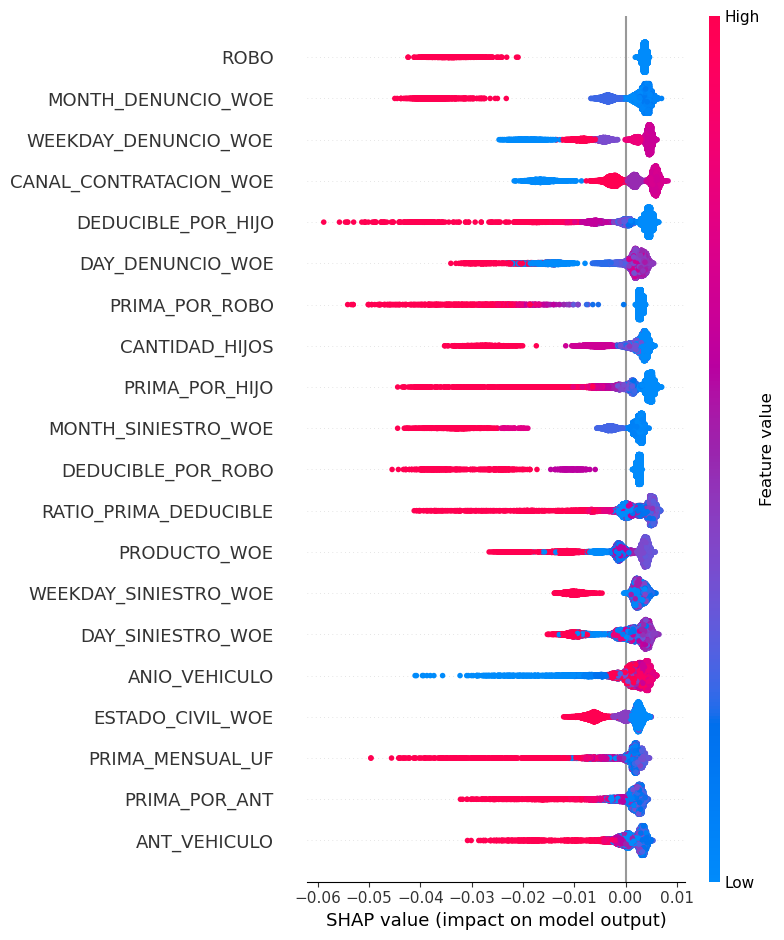

In [61]:
# Se buscará las variables que sean mejores para el modelo, usando los mismos datos ideales de contaminación que el caso entregado
import shap

# Entrenás el modelo
modelo = IsolationForest(contamination=0.0305, random_state=123)
modelo.fit(X)

# Calculás los SHAP values
explainer = shap.Explainer(modelo.decision_function, X)
shap_values = explainer(X)

# Visualizás la importancia
shap.summary_plot(shap_values, X)

##### Debido a la importancia de cada variable, se decide eliminar las últimas 7 variables por importancia, con tal de mejorar el rendimiento del modelo

In [ ]:
# Reentrenamos con el mejor contamination
best_model = IsolationForest(contamination=0.1, random_state=123)
best_model.fit(X)

df_iso_for['anomaly_score'] = best_model.decision_function(X)
df_iso_for['predicted_outlier'] = best_model.predict(X)  # -1 = outlier, 1 = normal

# Filtramos los casos predichos como fraude (-1)
casos_sospechosos = df_iso_for[df_iso_for['predicted_outlier'] == -1]

In [ ]:
casos_sospechosos